In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install arch

In [3]:
import sys
from tqdm import tqdm
import math
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline

In [4]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def smape(actual, predicted):
    return np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2)) * 100

In [6]:
!ls /content/gdrive/MyDrive/A1

results_1.csv  Task_1.ipynb  Task3.ipynb    Задания_1_2.xlsx
results_2.csv  Task_2.ipynb  Задание_3.zip


In [7]:
data = pd.read_excel('/content/gdrive/MyDrive/A1/Задания_1_2.xlsx')
print(data.shape)
data.head()

(1642, 2)


,Date,series1
0,2015-01-01,1006.699649
1,2015-01-02,3197.751826
2,2015-01-03,3217.491035
3,2015-01-04,2151.573759
4,2015-01-05,4243.929892


In [8]:
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")

In [9]:
# data.set_index('Date', inplace=True)

data['date'] = data.index
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.dayofyear
data['weekday'] = data['Date'].dt.weekday

data.set_index('Date', inplace=True)
data.head()

,series1,date,year,month,day,weekday
Date,,,,,,
2015-01-01,1006.699649,0,2015,1,1,3
2015-01-02,3197.751826,1,2015,1,2,4
2015-01-03,3217.491035,2,2015,1,3,5
2015-01-04,2151.573759,3,2015,1,4,6
2015-01-05,4243.929892,4,2015,1,5,0


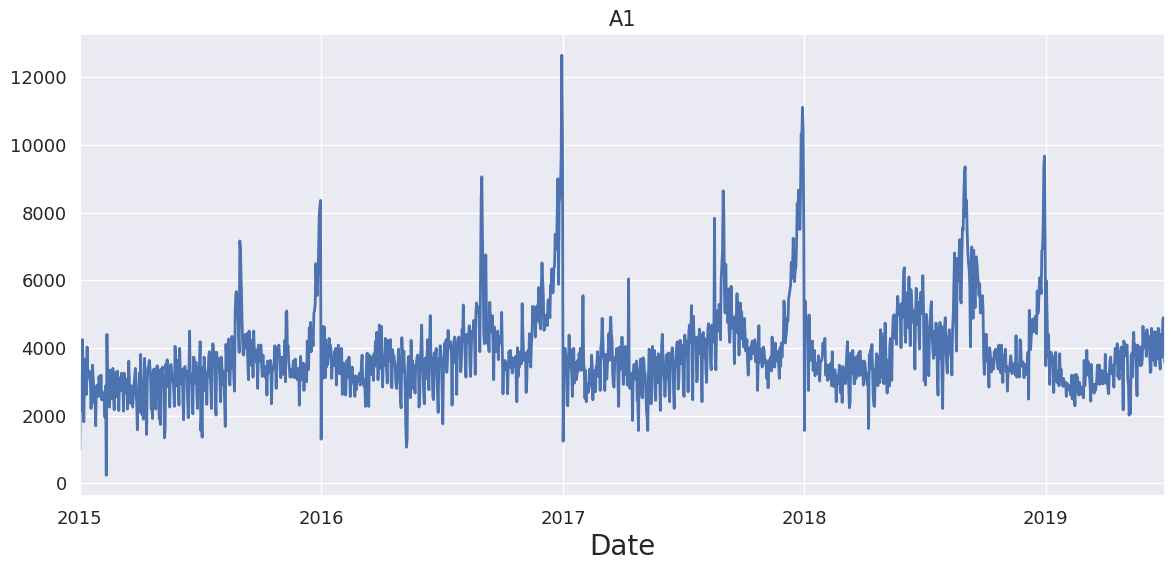

In [18]:
data.series1.plot(figsize=(14, 6), linewidth=2, fontsize=13)
plt.title('A1', fontsize=15)
plt.show()

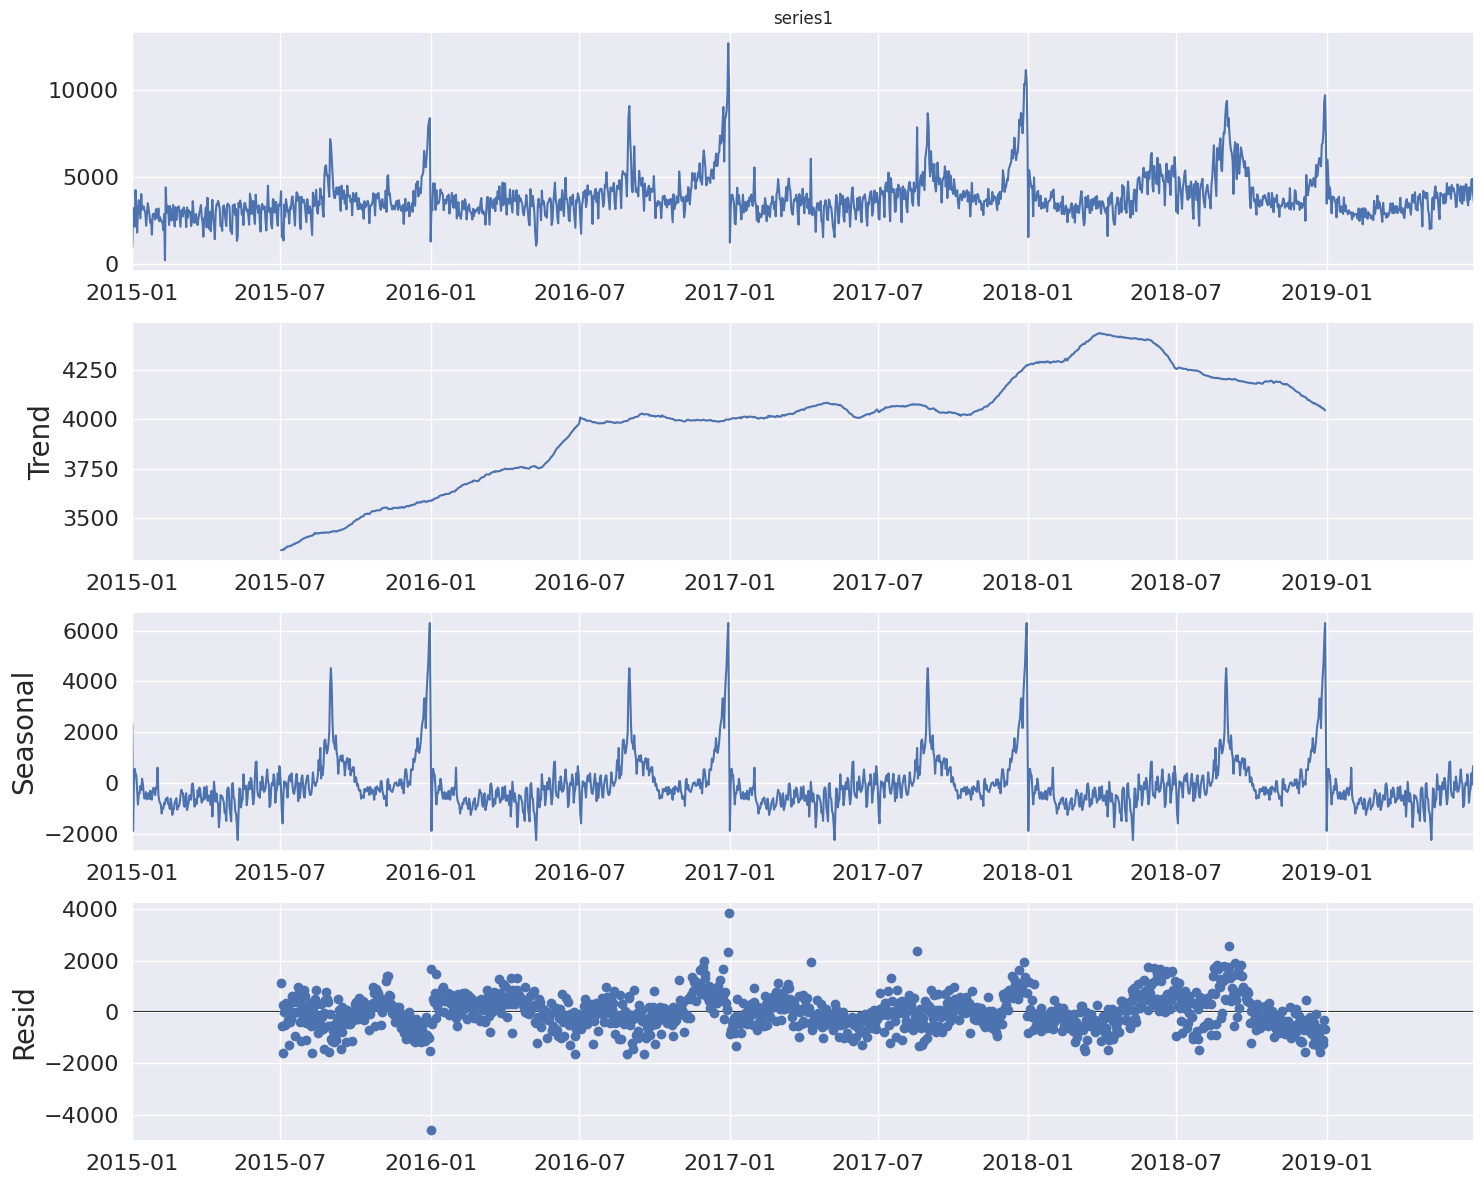

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
decomposition = sm.tsa.seasonal_decompose(data.series1, model='additive',period=365)
decomp = decomposition.plot()
# decomp.suptitle('Temperature Decomposition', fontsize=22)

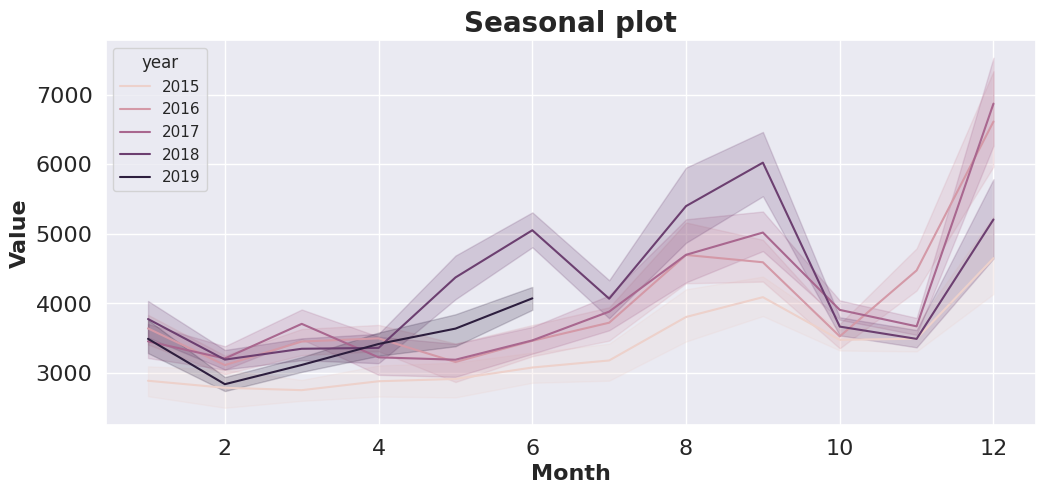

In [14]:
variable = 'series1'
fig, ax = plt.subplots(figsize=(12, 5))

sns.lineplot(data=data, x='month', y=variable, hue='year') #, palette=palette
ax.set_title('Seasonal plot', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Value', fontsize = 16, fontdict=dict(weight='bold'))
plt.show()

In [15]:
avg_classical_seasonal = data.groupby('weekday').agg({'series1': 'mean'})
daysofweek = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday',
}

avg_classical_seasonal.index = avg_classical_seasonal.index.map(daysofweek)
avg_classical_seasonal

,series1
weekday,
Monday,4011.883683
Tuesday,3996.992390
Wednesday,4045.846089
Thursday,4036.080224
Friday,4061.426208
Saturday,3704.862180
Sunday,3129.819549


In [16]:
r = [6 for i in range(9)]

theta = [i*np.pi/4 for i in range(9)]

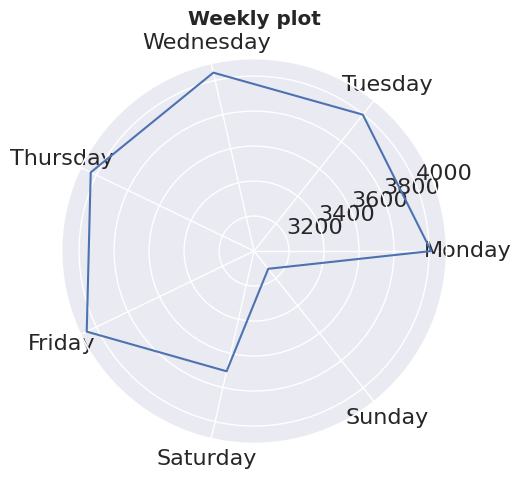

In [17]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0], projection='polar')
gs.update(wspace=0.01)

theta = [i*np.pi*2/7 for i in range(7)]
theta.append(theta[0])
r = list(avg_classical_seasonal.series1)
r.append(r[0])
ax1.plot(theta, r)
ax1.set_xticks([i*np.pi*2/7 for i in range(7)])
ax1.xaxis.set_tick_params(pad=2)
ax1.set_xticklabels(daysofweek.values())
ax1.set_ylim(3000, 4100)
ax1.set_title('Weekly plot', fontsize='large', fontweight='bold')
plt.show()

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax) #, alpha=0.5
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax) # , alpha=0.5

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.000002


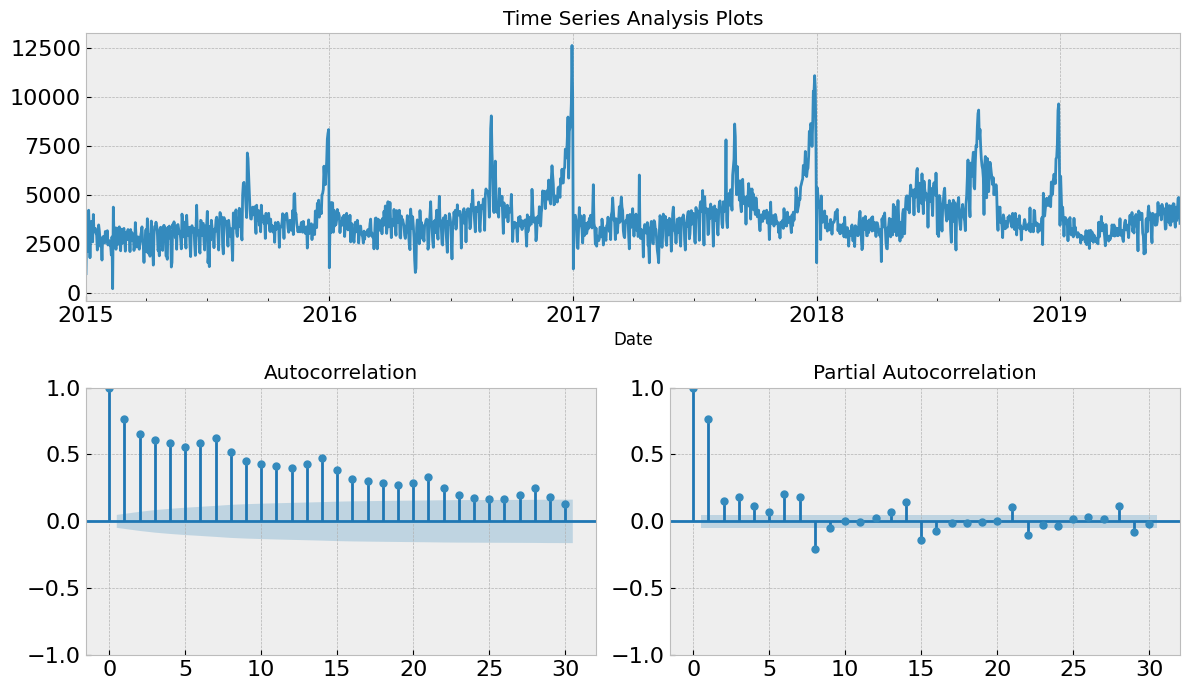

In [ ]:
tsplot(data.series1, lags=30)

Критерий Дики-Фуллера: p=0.000000


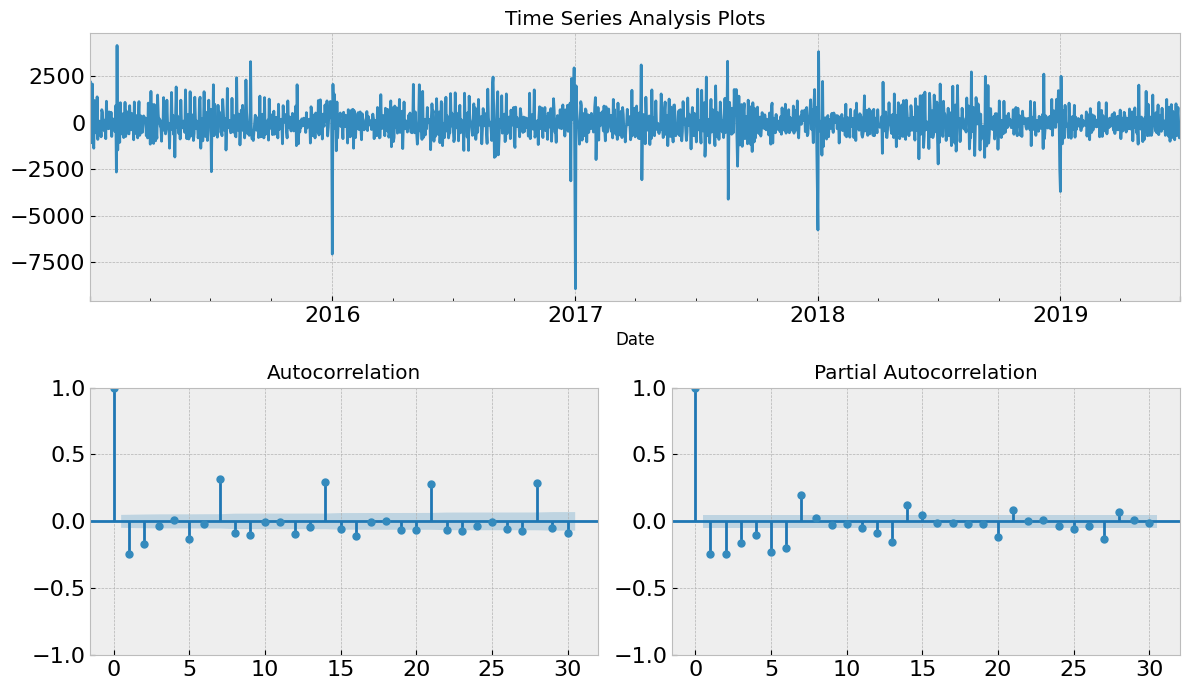

In [ ]:
data['diff'] = data.series1 - data.series1.shift(1)
tsplot(data['diff'][1:], lags=30)

In [ ]:
from itertools import product


d, D = 1, 1 
ps = range(6, 7) 
qs = range(6, 7) 
Ps = range(6, 7) 
Qs = range(1, 7)

parameters_list = list(product(ps, qs, Ps, Qs))

In [ ]:
actual = data.series1[1549:]

In [ ]:
results, best_mapee = [], 20
best_aic = float("inf")
warnings.filterwarnings('ignore')
train = data.series1[:1549]

for param in parameters_list:

    try:
        model=sm.tsa.statespace.SARIMAX(train, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)

    except ValueError:
        continue

    aic = model.aic
    forecast_i = model.predict(start = '2019-03-30', end = '2019-06-30')
    score = round(mean_absolute_error(actual, forecast_i))
    mapee = mape(train, forecast_i)
    
    if mapee < best_mapee:
        best_model = model
        best_mapee = mapee
        best_param = param
    results.append([param, model.aic, score, mapee])
    
warnings.filterwarnings('default')

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic', 'score', 'mape']
print(result_table.sort_values(by = 'mape', ascending=True))

     parameters          aic  score       mape
1  (6, 6, 6, 2)  1347.450704    424  12.791501
0  (6, 6, 6, 1)  1345.595147    425  12.831726
5  (6, 6, 6, 6)  1355.077601    427  12.877741
4  (6, 6, 6, 5)  1353.088419    428  12.886368
3  (6, 6, 6, 4)  1354.260816    435  13.090770
2  (6, 6, 6, 3)  1352.342884    438  13.191840


In [ ]:
import warnings
warnings.filterwarnings("ignore")

Критерий Дики-Фуллера: p=0.000000


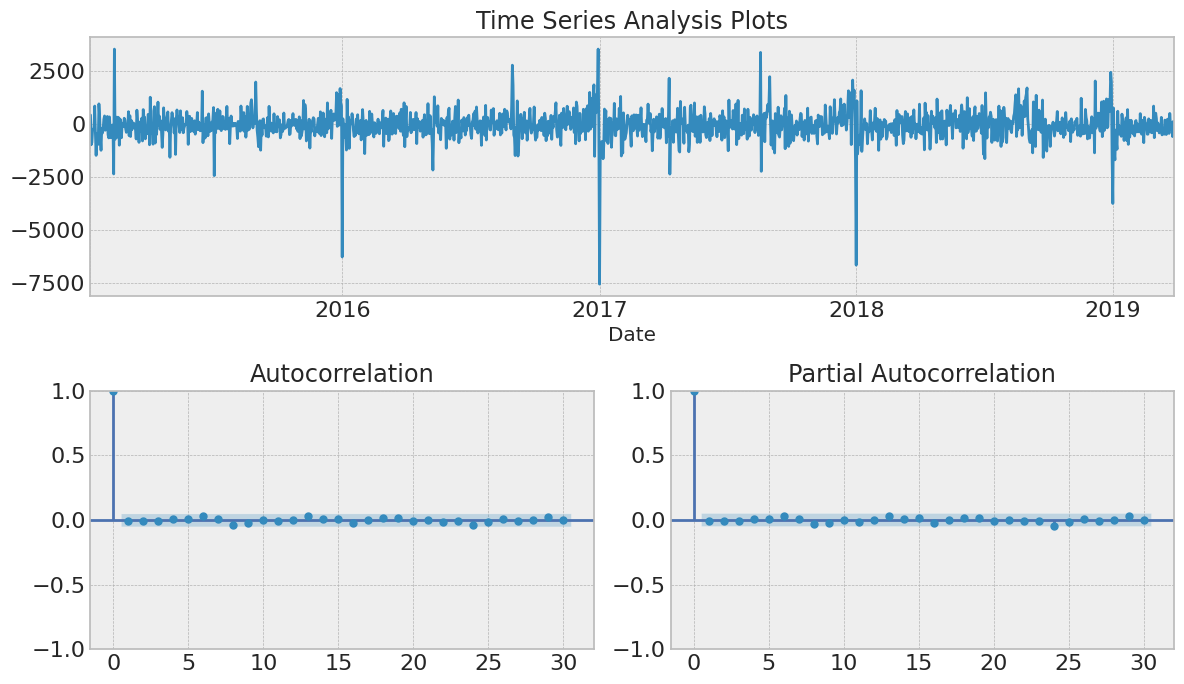

In [ ]:
d, D = 1, 1

best_model_one=sm.tsa.statespace.SARIMAX(data.series1[:1549], order=(6, d, 6), seasonal_order=(6, D, 2, 7)).fit(disp=-1)
tsplot(best_model_one.resid[7:], lags=30)

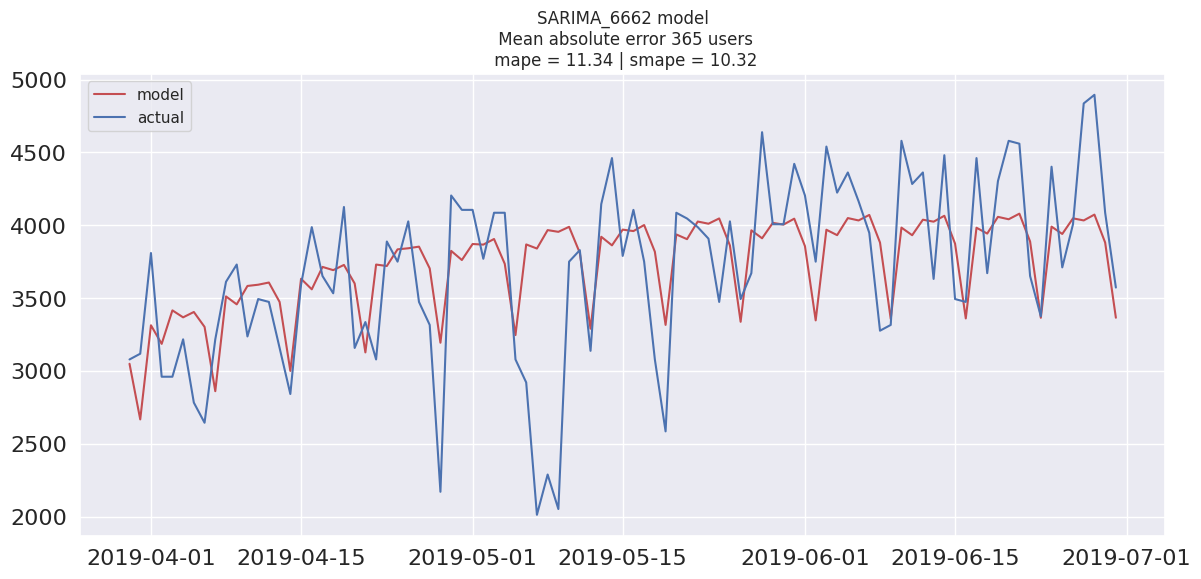

In [ ]:
forecast_one = best_model_one.predict(start = '2019-03-30', end = '2019-06-30')
actual = data.series1[1549:]
plt.figure(figsize=(14, 6))
plt.plot(forecast_one, color='r', label="model")
plt.title("SARIMA_6662 model\n Mean absolute error {MAE} users\n mape = {mape} | smape = {smape}".format(
                                                                                 MAE=round(mean_absolute_error(data.series1[1549:], forecast_one)),
                                                                                 mape=round(mape(actual, forecast_one), 2),
                                                                                 smape=round(smape(actual, forecast_one), 2)))
plt.plot(actual, label="actual")
plt.legend()
# plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

# **ETNA**

In [ ]:
!pip install etna

In [ ]:
from etna.analysis import plot_imputation
from etna.transforms import TimeSeriesImputerTransform
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.transforms import DensityOutliersTransform
from etna.metrics import SMAPE

In [ ]:
df = pd.DataFrame(data[:1549].reset_index().series1.copy()).rename(columns={'series1': 'target'})
df['timestamp'] = data[:1549].index
df["segment"] = "main"
print(df.shape)
df.head()

(1549, 3)


,target,timestamp,segment
0,1006.699649,2015-01-01,main
1,3197.751826,2015-01-02,main
2,3217.491035,2015-01-03,main
3,2151.573759,2015-01-04,main
4,4243.929892,2015-01-05,main


In [ ]:
from etna.datasets.tsdataset import TSDataset

df = TSDataset.to_dataset(df)

In [ ]:
ts = TSDataset(df,freq='D')
ts.head()

segment,main
feature,target
timestamp,
2015-01-01,1006.699649
2015-01-02,3197.751826
2015-01-03,3217.491035
2015-01-04,2151.573759
2015-01-05,4243.929892


In [ ]:
ts1 = TSDataset(df,freq='1d')

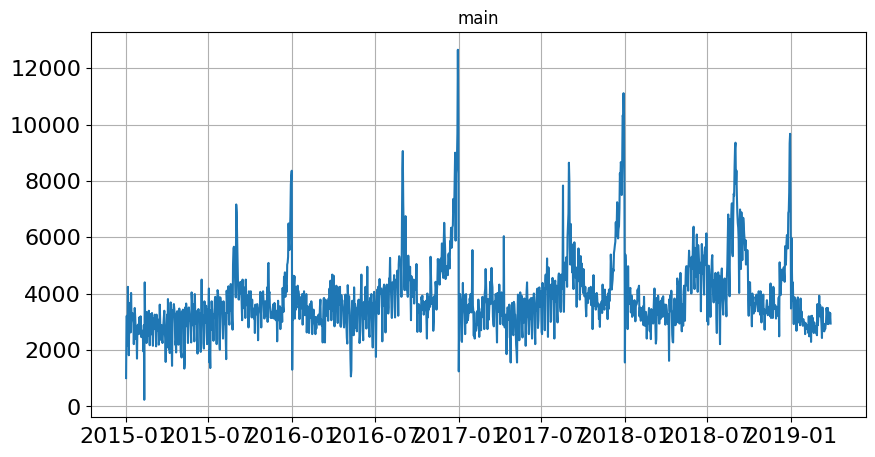

In [ ]:
ts.plot()

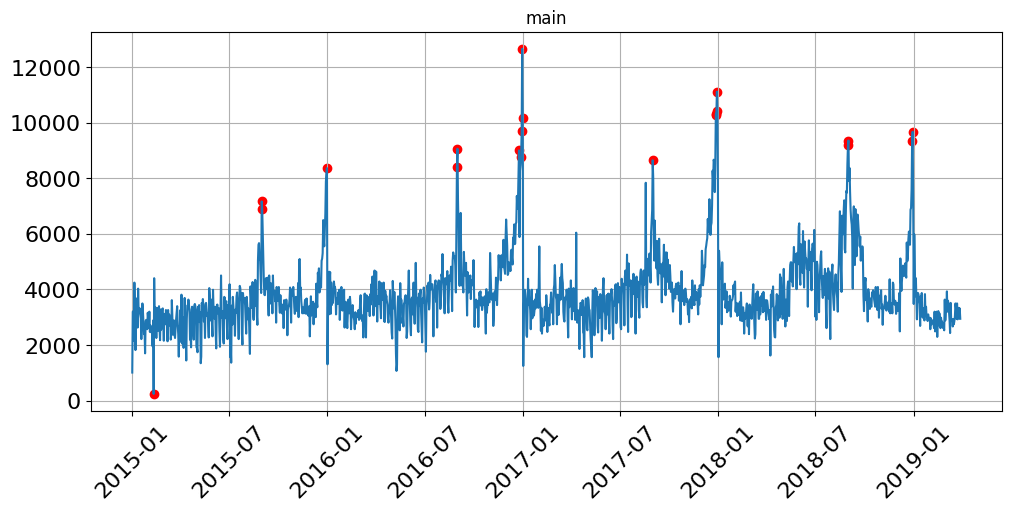

In [ ]:
from etna.analysis import plot_anomalies, get_anomalies_density

anomalies = get_anomalies_density(ts1, window_size=365, distance_coef=1, n_neighbors=12)
plot_anomalies(ts1, anomalies)

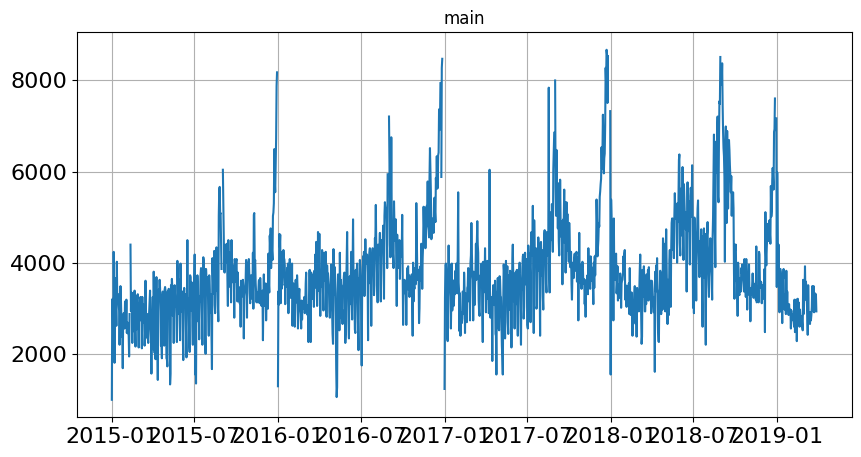

In [ ]:
from etna.analysis import plot_imputation
from etna.transforms import TimeSeriesImputerTransform

outliers_remover = DensityOutliersTransform(in_column="target", window_size=365, n_neighbors=12, distance_coef=1)
ts1.fit_transform([outliers_remover])
ts1.plot()
imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=3)

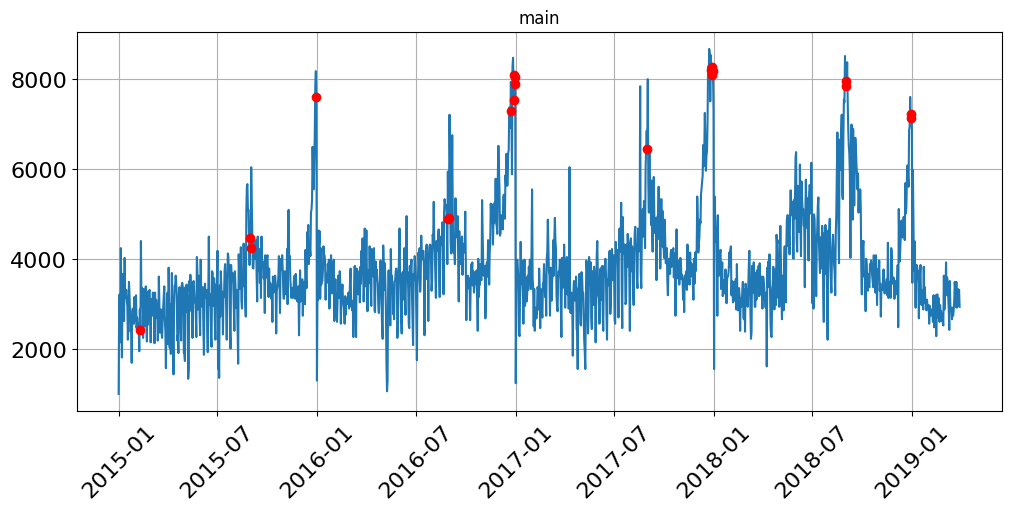

In [ ]:
plot_imputation(ts1, imputer)
ts1.fit_transform([imputer])

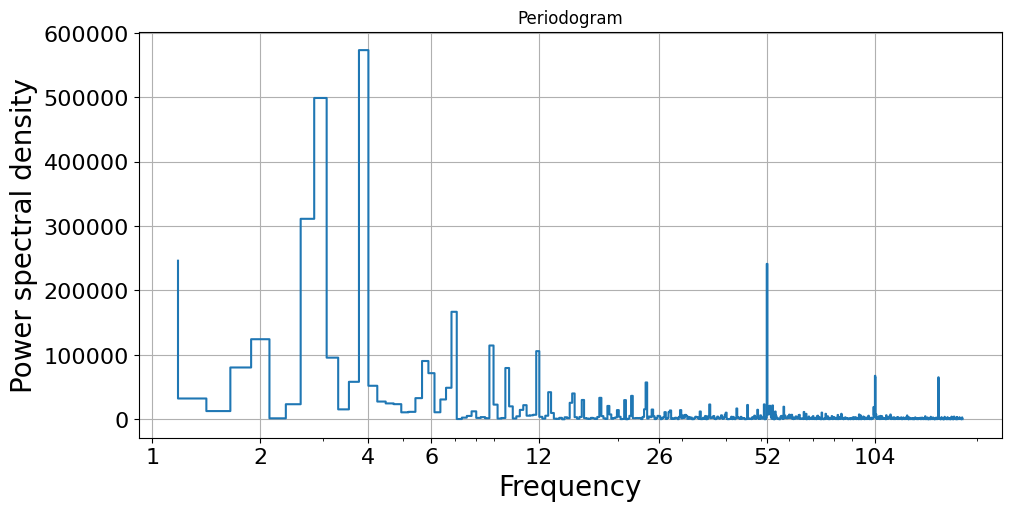

In [ ]:
from etna.analysis import plot_periodogram

plot_periodogram(ts, period=365.25, xticks=[1, 2, 4, 6, 12, 26, 52, 104])

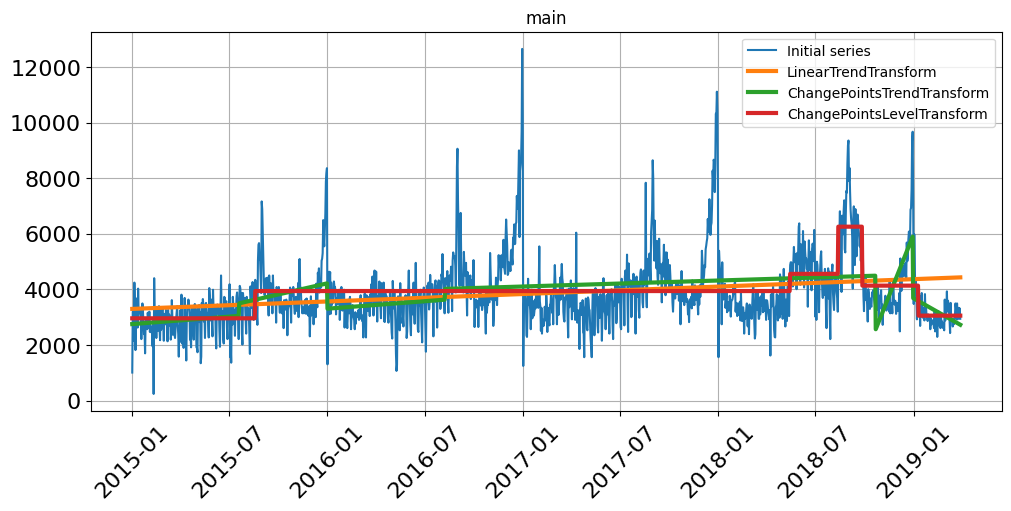

In [ ]:
from etna.analysis import plot_trend
from etna.transforms import LinearTrendTransform, TheilSenTrendTransform, ChangePointsTrendTransform, ChangePointsLevelTransform

plot_trend(
    ts=ts,
    trend_transform=[
        LinearTrendTransform(in_column="target"),
        ChangePointsTrendTransform(in_column="target"),
        ChangePointsLevelTransform(in_column="target")
    ],
)

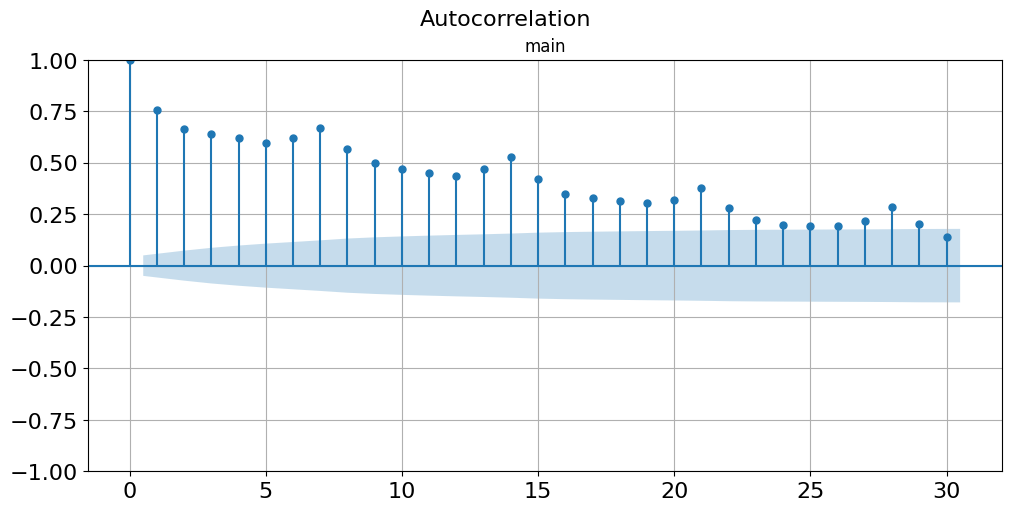

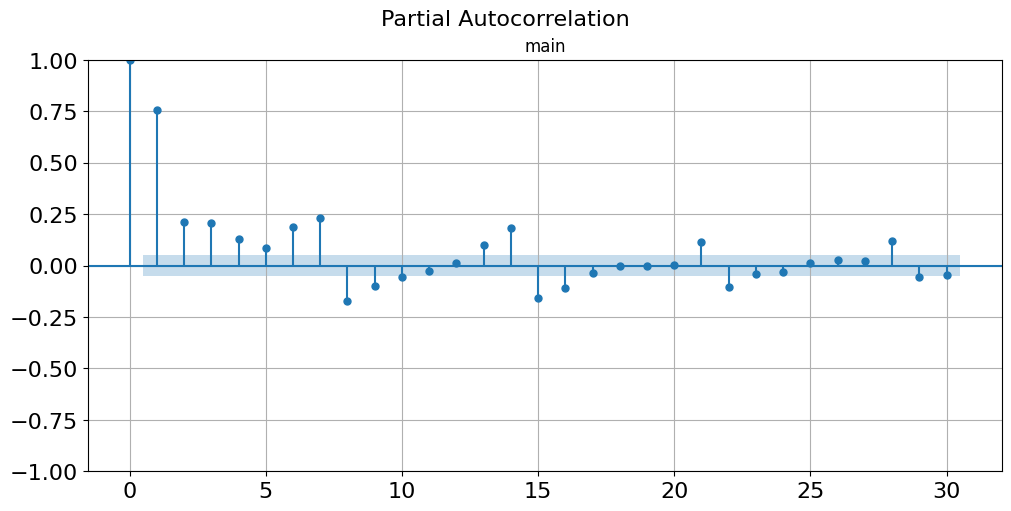

In [ ]:
from etna.analysis import acf_plot

ts1.fit_transform([TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=3)])
acf_plot(ts1, lags=30)
acf_plot(ts1, lags=30, partial=True)

In [ ]:
from etna.models import CatBoostPerSegmentModel
from etna.analysis import plot_backtest
from etna.transforms import LagTransform, DateFlagsTransform, FourierTransform, HolidayTransform

HORIZON = 93
pipeline = Pipeline(
    model=CatBoostPerSegmentModel(),
    transforms=[
        LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON + 7))),
        FourierTransform(period=365.25, order=4),
        DateFlagsTransform(day_number_in_week=True, day_number_in_month=False,
                           is_weekend=True, month_number_in_year=False, special_days_in_week=[6],),
        HolidayTransform(iso_code='RUS')
    ],
    horizon=HORIZON,
)

metrics, forecast, _ = pipeline.backtest(ts, metrics=[SMAPE()], n_folds=3, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.3s finished
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [ ]:
metrics

,segment,SMAPE,fold_number
0,main,17.490134,0
0,main,17.072598,1
0,main,13.983505,2


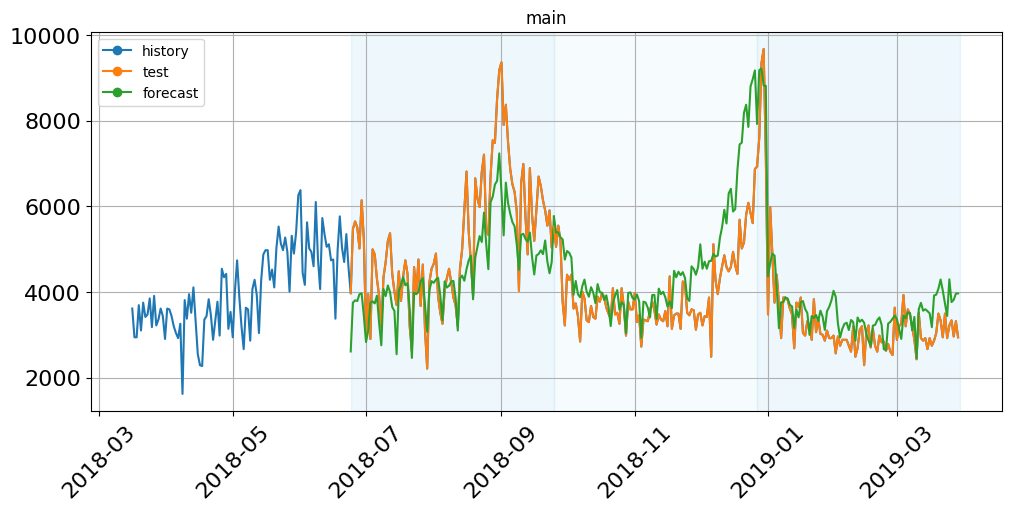

In [ ]:
plot_backtest(forecast, ts, history_len=100)

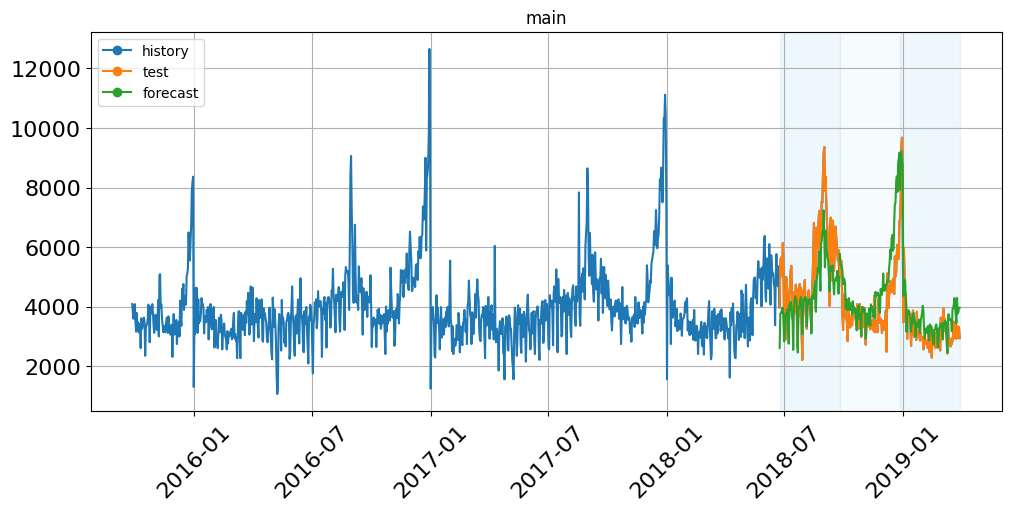

In [ ]:
plot_backtest(forecast, ts, history_len=1000)

In [ ]:
df = pd.DataFrame(data[1500:].reset_index().series1.copy()).rename(columns={'series1': 'target'})
df['timestamp'] = data[1500:].index
df["segment"] = "main"
df = TSDataset.to_dataset(df)
true = TSDataset(df,freq='D')

In [ ]:
df = pd.DataFrame(data[:1549].reset_index().series1.copy()).rename(columns={'series1': 'target'})
df['timestamp'] = data[:1549].index
df["segment"] = "main"
df = TSDataset.to_dataset(df)
ts_train = TSDataset(df,freq='D')

In [ ]:
pipeline.fit(ts_train)

Pipeline(model = CatBoostPerSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LagTransform(in_column = 'target', lags = [93, 94, 95, 96, 97, 98, 99], out_column = None, ), FourierTransform(period = 365.25, order = None, mods = [1, 2, 3, 4, 5, 6, 7, 8], out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = [6], special_days_in_month = (), out_column = None, ), HolidayTransform(iso_code = 'RUS', out_column = None, )], horizon = 93, )

In [ ]:
future = pipeline.forecast()

In [ ]:
actual = data.series1[1549:]

In [ ]:
# lags7 + holiday
mape(actual, future[:, 'main', 'target']), round(mean_absolute_error(actual, future[:, 'main', 'target']))

(12.125341071843081, 434)

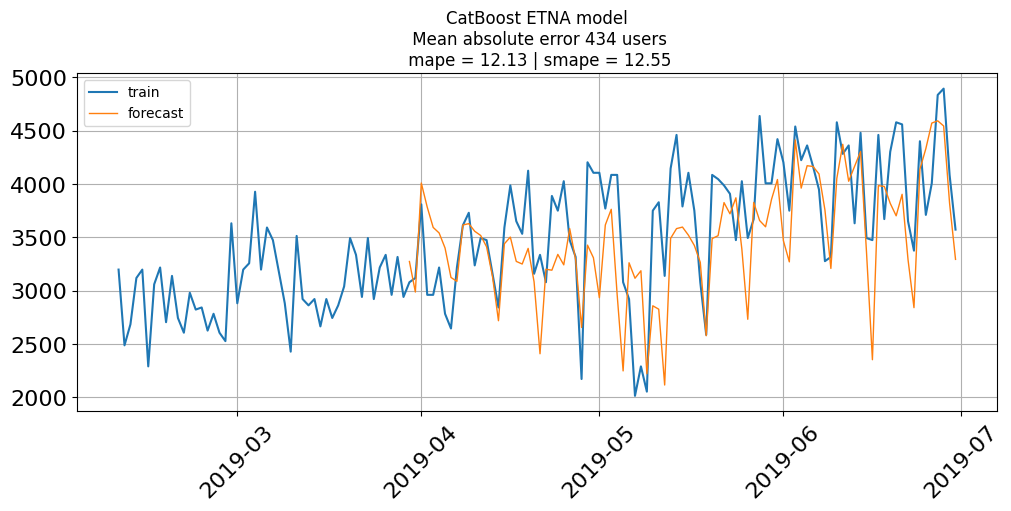

In [ ]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts = future, train_ts=true)
plt.title("CatBoost ETNA model\n Mean absolute error {MAE} users\n mape = {mape} | smape = {smape}".format(
                                                                                 MAE=round(mean_absolute_error(actual, future[:, 'main', 'target'])),
                                                                                 mape=round(mape(actual, future[:, 'main', 'target']), 2),
                                                                                 smape=round(smape(actual, future[:, 'main', 'target']), 2)))
plt.show()

In [ ]:
final_model=sm.tsa.statespace.SARIMAX(data.series1, order=(6, d, 6), seasonal_order=(6, D, 2, 7)).fit(disp=-1)

In [ ]:
results = final_model.predict(start = '2019-07-01', end = '2019-09-30')

In [ ]:
results = pd.DataFrame(results)

In [ ]:
results.index.names = ['Date']

In [ ]:
results.to_csv('results_1.csv')